### Player Points

This notebook trains and predict a model to predict how likely any given player is to record a point (goal or assist) in an NHL game. We fit XGBoost models, with Bayesian cross-validation to lessen the risk of over-fitting. Finally, we compare these predictions with historical betting odds from sportsbooks across the US.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from credentials import HOCKEY_DB_NAME, HOCKEY_DB_PWD
from schedule import get_schedule
from datetime import date
from betting_utils import convert_prob_to_american
import seaborn as sns
import requests

import datetime as dt
from datetime import date, timedelta
from pytz import timezone

import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def make_synthetic_roster(r):
    game_pk = r['game_pk']
    game_date = r['game_date']
    home_team = r['home_team']
    away_team = r['away_team']
    
    away_players = [x['roster']['roster'] for x in rosters['teams'] if x['name'] == away_team][0]
    away_players = pd.concat([make_synthetic_boxscore(x) for x in away_players])
    away_players['team'] = away_team
    away_players['opposing_team'] = home_team
    away_players['is_home_team'] = 0
    
    home_players = [x['roster']['roster'] for x in rosters['teams'] if x['name'] == home_team][0]
    home_players = pd.concat([make_synthetic_boxscore(x) for x in home_players])
    home_players['team'] = home_team
    home_players['opposing_team'] = away_team
    home_players['is_home_team'] = 1

    players = pd.concat([home_players, away_players])
    players['game_pk'] = game_pk
    players['game_date'] = game_date
    players['game_final'] = False
    
    return(players)
    
def make_synthetic_boxscore(b):
    person = b['person']
    position = b['position']
    is_goalie = position['name'] == "Goalie"
    
    return(pd.DataFrame({"player_id": person['id']
                         , "player_name": person['fullName']
                         , "position": position['name']
                         , "is_goalie": position['name'] == 'Goalie'
                         }, index = [1]))

In [3]:
s = get_schedule(startdate = date.today(), enddate = date.today())

rosters = requests.get('https://statsapi.web.nhl.com/api/v1/teams/', params={'expand': 'team.roster'}).json()

s['game_date'] = pd.to_datetime(s['game_date'])
s['game_date'] = s['game_date'].apply(lambda x: x.astimezone(timezone('US/Eastern')))
s['game_date'] = s['game_date'].apply(lambda x: x.tz_localize(None))
s

,game_pk,game_type,game_date,game_final,home_team,away_team,home_score,away_score
0,2022020365,R,2022-12-01 19:00:00,False,Buffalo Sabres,Colorado Avalanche,-1,-1
1,2022020366,R,2022-12-01 19:00:00,False,New Jersey Devils,Nashville Predators,-1,-1
2,2022020367,R,2022-12-01 19:00:00,False,Philadelphia Flyers,Tampa Bay Lightning,-1,-1
3,2022020368,R,2022-12-01 19:00:00,False,Pittsburgh Penguins,Vegas Golden Knights,-1,-1
4,2022020369,R,2022-12-01 20:00:00,False,St. Louis Blues,Carolina Hurricanes,-1,-1
5,2022020370,R,2022-12-01 20:00:00,False,Minnesota Wild,Edmonton Oilers,-1,-1
6,2022020371,R,2022-12-01 20:30:00,False,Dallas Stars,Anaheim Ducks,-1,-1
7,2022020372,R,2022-12-01 21:00:00,False,Calgary Flames,Montréal Canadiens,-1,-1
8,2022020373,R,2022-12-01 22:00:00,False,Vancouver Canucks,Florida Panthers,-1,-1
9,2022020374,R,2022-12-01 22:00:00,False,Seattle Kraken,Washington Capitals,-1,-1


In [4]:
synth_today = pd.concat([make_synthetic_roster(a) for i, a in s.iterrows()])
synth_today

,player_id,player_name,position,is_goalie,team,opposing_team,is_home_team,game_pk,game_date,game_final
1,8477480,Eric Comrie,Goalie,True,Buffalo Sabres,Colorado Avalanche,1,2022020365,2022-12-01 19:00:00,False
1,8480196,Jacob Bryson,Defenseman,False,Buffalo Sabres,Colorado Avalanche,1,2022020365,2022-12-01 19:00:00,False
1,8467950,Craig Anderson,Goalie,True,Buffalo Sabres,Colorado Avalanche,1,2022020365,2022-12-01 19:00:00,False
1,8473449,Kyle Okposo,Right Wing,False,Buffalo Sabres,Colorado Avalanche,1,2022020365,2022-12-01 19:00:00,False
1,8475784,Jeff Skinner,Left Wing,False,Buffalo Sabres,Colorado Avalanche,1,2022020365,2022-12-01 19:00:00,False
...,...,...,...,...,...,...,...,...,...,...
1,8480849,Barrett Hayton,Center,False,Arizona Coyotes,Los Angeles Kings,0,2022020375,2022-12-01 22:30:00,False
1,8480855,Jack McBain,Center,False,Arizona Coyotes,Los Angeles Kings,0,2022020375,2022-12-01 22:30:00,False
1,8481711,Matias Maccelli,Left Wing,False,Arizona Coyotes,Los Angeles Kings,0,2022020375,2022-12-01 22:30:00,False
1,8482655,J.J. Moser,Defenseman,False,Arizona Coyotes,Los Angeles Kings,0,2022020375,2022-12-01 22:30:00,False


### Get real data

In [5]:
engine = create_engine('postgresql://baseball:{}@localhost:5432/{}'.format(HOCKEY_DB_PWD, HOCKEY_DB_NAME))

In [6]:
dat = pd.read_sql("""SELECT b.*, s.game_date
, CASE WHEN b.team = s.home_team THEN 1 ELSE 0 END AS is_home_team
, True AS game_final
FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2019-06-01';""", engine)

In [7]:
dat = pd.concat([dat, synth_today]).reset_index()

In [8]:
dat = dat.sort_values(['game_date', 'game_pk', 'player_id'])

In [9]:
dat['points'] = (dat['assists'] + dat['goals'])

dat['score_point'] = 1.0 * ((dat['assists'] + dat['goals']) >= 1)


In [10]:
dat['player_l10_points_mean'] = dat.groupby(['player_id'])['points'].apply(lambda x: x.shift().rolling(10).mean())
dat['player_l10_gt1_points_mean'] = dat.groupby(['player_id'])['points'].apply(lambda x: (x.shift() >= 1).rolling(10).mean())

dat['player_l25_points_mean'] = dat.groupby(['player_id'])['points'].apply(lambda x: x.shift().rolling(25).mean())
dat['player_l25_gt1_points_mean'] = dat.groupby(['player_id'])['points'].apply(lambda x: (x.shift() >= 1).rolling(25).mean())

dat['player_l10_points_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['points'].apply(lambda x: x.shift().rolling(10).mean())
dat['player_l10_gt1_points_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['points'].apply(lambda x: (x.shift() >= 1).rolling(10).mean())

dat['player_l25_points_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['points'].apply(lambda x: x.shift().rolling(25).mean())
dat['player_l25_gt1_points_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['points'].apply(lambda x: (x.shift() >= 1).rolling(25).mean())

dat['player_l10_points_mean_opponent'] = dat.groupby(['player_id', 'opposing_team'])['points'].apply(lambda x: x.shift().rolling(5).mean()).fillna(0)
dat['player_l10_gt1_points_mean_opponent'] = dat.groupby(['player_id', 'opposing_team'])['points'].apply(lambda x: (x.shift() >= 1).rolling(5).mean()).fillna(0)

In [11]:
opponent = dat.groupby(['opposing_team', 'game_pk', 'game_date'])['points'].sum().reset_index()
opponent = opponent.sort_values(['game_date', 'game_pk', 'opposing_team'])

opponent['opponent_l10_points_mean'] = opponent.groupby(['opposing_team'])['points'].apply(lambda x: x.shift().rolling(10).mean())
opponent['opponent_l25_points_mean'] = opponent.groupby(['opposing_team'])['points'].apply(lambda x: x.shift().rolling(25).mean())

#opponent

In [12]:
opp_position = dat.groupby(['opposing_team', 'game_pk', 'game_date', 'position'])['points'].sum().reset_index()

opp_position = opp_position.sort_values(['game_date', 'game_pk', 'opposing_team', 'position'])

opp_position['opp_pos_l10_points_mean'] = opp_position.groupby(['opposing_team', 'position'])['points'].apply(lambda x: x.shift().rolling(10).mean())
opp_position['opp_pos_l25_points_mean'] = opp_position.groupby(['opposing_team', 'position'])['points'].apply(lambda x: x.shift().rolling(25).mean())

#opp_position

In [13]:
myteam = dat.groupby(['team', 'game_pk', 'game_date'])['points'].sum().reset_index()
myteam = myteam.sort_values(['game_date', 'game_pk', 'team'])

myteam['team_l10_points_mean'] = myteam.groupby(['team'])['points'].apply(lambda x: x.shift().rolling(10).mean())
myteam['team_l25_points_mean'] = myteam.groupby(['team'])['points'].apply(lambda x: x.shift().rolling(25).mean())

#myteam

In [14]:
dat = dat.merge(myteam[['team', 'game_pk', 'game_date', 'team_l10_points_mean', 'team_l25_points_mean']]
                       , on = ['team', 'game_pk', 'game_date'])

dat = dat.merge(opponent[['opposing_team', 'game_pk', 'game_date', 'opponent_l10_points_mean', 'opponent_l25_points_mean']]
                       , on = ['opposing_team', 'game_pk', 'game_date'])

dat = dat.merge(opp_position[['opposing_team', 'position', 'game_pk', 'game_date', 'opp_pos_l10_points_mean', 'opp_pos_l25_points_mean']]
                       , on = ['opposing_team', 'position', 'game_pk', 'game_date'])

In [15]:
dat = dat.query('player_l25_gt1_points_mean >= 0.20')

In [16]:
train_dat = dat.query('game_final == True')

In [17]:
X_train = train_dat[['is_home_team', 'player_l10_points_mean', 'player_l10_gt1_points_mean',
'player_l25_points_mean', 'player_l25_gt1_points_mean',
'player_l10_points_mean_homeaway', 'player_l10_gt1_points_mean_homeaway',
'player_l25_points_mean_homeaway', 'player_l25_gt1_points_mean_homeaway',
'team_l10_points_mean', 'team_l25_points_mean',
'opponent_l10_points_mean', 'opponent_l25_points_mean',
'opp_pos_l10_points_mean', 'opp_pos_l25_points_mean']]

y_train = train_dat['score_point']


In [18]:
from skopt import BayesSearchCV
import numpy as np
from skopt.plots import plot_objective, plot_histogram

val. score: -0.22071204691699817
best params: OrderedDict([('alpha', 1), ('gamma', 0), ('max_depth', 3), ('min_child_weight', 2), ('n_estimators', 58)])


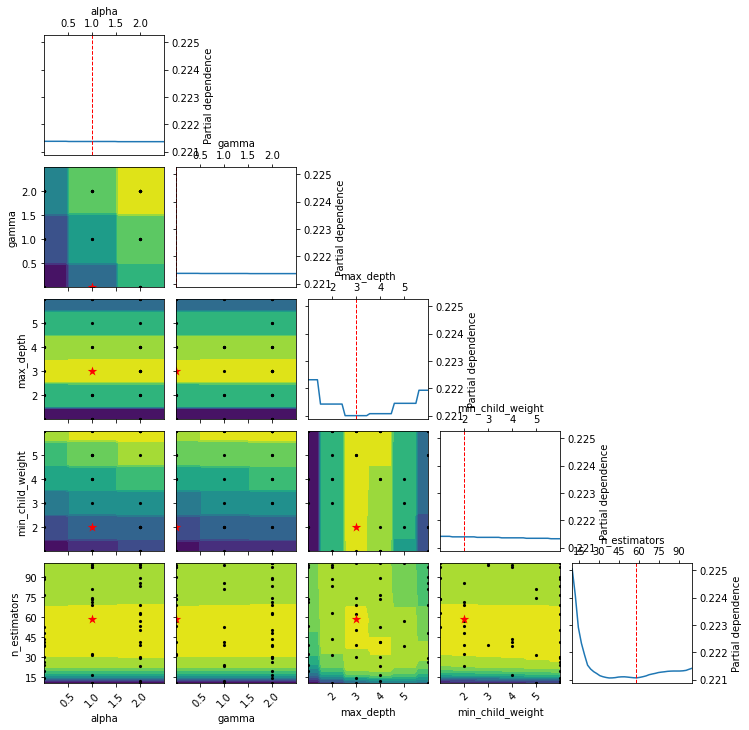

In [19]:
search1 = BayesSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1
                                                      , objective= 'binary:logistic'
                                                      , nthread=4, scale_pos_weight=1
                                                      , seed=27), 
                        search_spaces = {'n_estimators': (10, 100)
                        , 'max_depth': (1, 6)
                        , 'min_child_weight': (1, 6)
                        , 'alpha':(0, 2.5, 'uniform')
                        , 'gamma': (0, 2.5, 'uniform')}
                        , scoring='neg_brier_score',n_jobs=4, cv=5)
search1.fit(X_train,y_train)

print("val. score: %s" % search1.best_score_)
print("best params: %s" % str(search1.best_params_))

_ = plot_objective(search1.optimizer_results_[0],
                   dimensions=None,
                   n_minimum_search=int(1e8))
plt.show()

In [20]:
#xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42
#                              , max_depth = 3, min_child_weight = 1, n_estimators = 50
#                              , gamma = 2, alpha = 2, learning_rate = 0.1)
#xgb_model.fit(X_train, y_train)

y_pred_train = search1.predict_proba(X_train)


In [21]:
X = dat[['is_home_team', 'player_l10_points_mean', 'player_l10_gt1_points_mean',
'player_l25_points_mean', 'player_l25_gt1_points_mean',
'player_l10_points_mean_homeaway', 'player_l10_gt1_points_mean_homeaway',
'player_l25_points_mean_homeaway', 'player_l25_gt1_points_mean_homeaway',
'team_l10_points_mean', 'team_l25_points_mean',
'opponent_l10_points_mean', 'opponent_l25_points_mean',
'opp_pos_l10_points_mean', 'opp_pos_l25_points_mean']]

y_pred = search1.predict_proba(X)

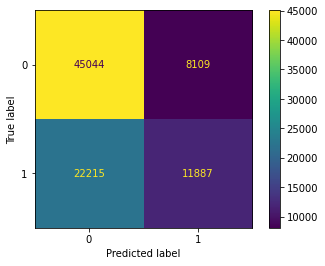

In [22]:
p = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train[:, 1] >= 0.5))
p.plot()
plt.show()

In [23]:
dat['pred_point'] = search1.predict_proba(X)[:, 1]
dat['odds'] = dat['pred_point'].apply(convert_prob_to_american)

In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Get today odds

In [36]:
import requests
import json
from bs4 import BeautifulSoup
import re 

# Create an URL object
url = 'https://www.rotowire.com/betting/nhl/player-props.php'
# Create object page
page = requests.get(url)

soup = BeautifulSoup(page.text)

In [37]:
results = re.findall(pattern = 'data: (.+])', string = soup.prettify())
odds = {}
for res in results:
    try:
        records = re.sub(pattern = '},{', repl= '}***{', string=res[1:-1]).split('***')
        records_df = pd.concat([pd.DataFrame(json.loads(rec), index = [1]) for rec in records])
        odds[records_df.columns[9]] = records_df
    
        print(records_df.columns[9])
        
    except:
        pass

draftkings_firstgoal
mgm_anygoal
draftkings_anypoint
draftkings_ast
mgm_pppt
draftkings_shot
draftkings_firstgoal
draftkings_firstgoal


In [38]:
odds['draftkings_ast']

,gameID,playerID,firstName,lastName,name,team,opp,logo,playerLink,draftkings_ast,draftkings_astUnder,draftkings_astOver,mgm_ast,mgm_astUnder,mgm_astOver,fanduel_ast,fanduel_astUnder,fanduel_astOver,pointsbet_ast,pointsbet_astUnder,pointsbet_astOver
1,2466016,4778,Mathew,Barzal,Mathew Barzal,NYI,NSH,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/mathew-barzal-odds-4778,0.5,,,0.5,150,-200,None,None,None,None,None,None
1,2466015,5604,Drake,Batherson,Drake Batherson,OTT,@NYR,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/drake-batherson-odds-5604,0.5,,,0.5,-208,155,None,None,None,None,None,None
1,2466015,4784,Thomas,Chabot,Thomas Chabot,OTT,@NYR,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/thomas-chabot-odds-4784,0.5,,,0.5,-208,155,None,None,None,None,None,None
1,2466017,4783,Kyle,Connor,Kyle Connor,WPG,CLS,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/kyle-connor-odds-4783,0.5,100,-130,0.5,-105,-128,None,None,None,None,None,None
1,2466015,5149,Alex,DeBrincat,Alex DeBrincat,OTT,@NYR,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/alex-debrincat-odds-5149,0.5,,,0.5,-189,140,None,None,None,None,None,None
1,2466016,5700,Noah,Dobson,Noah Dobson,NYI,NSH,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/noah-dobson-odds-5700,0.5,,,0.5,-189,140,None,None,None,None,None,None
1,2466017,5130,Pierre-Luc,Dubois,Pierre-Luc Dubois,WPG,CLS,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/pierre-luc-dubois-odds-5130,0.5,-135,105,0.5,-143,105,None,None,None,None,None,None
1,2466016,3249,Matt,Duchene,Matt Duchene,NSH,@NYI,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/matt-duchene-odds-3249,0.5,,,0.5,-208,155,None,None,None,None,None,None
1,2466016,3971,Filip,Forsberg,Filip Forsberg,NSH,@NYI,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/filip-forsberg-odds-3971,0.5,,,0.5,-167,125,None,None,None,None,None,None
1,2466015,5207,Adam,Fox,Adam Fox,NYR,OTT,https://content.rotowire.com/images/teamlogo/h...,/betting/nhl/player/adam-fox-odds-5207,0.5,,,0.5,,,None,None,None,None,None,None


In [27]:
today_games = dat.query('game_final == False')

In [28]:
today_games = today_games.merge(odds['draftkings_anypoint'][['name', 'draftkings_anypoint', 'fanduel_anypoint', 'mgm_anypoint']]
                                , left_on = ['player_name'], right_on = ['name'], how='left')

In [29]:
for i, r in s.iterrows():
    print(r['away_team'])
    display(today_games.query('game_final == False & team == \"{}\"'.format(r['away_team']))[['game_date', 'player_name', 'points', 'pred_point', 'odds', 'draftkings_anypoint', 'fanduel_anypoint', 'mgm_anypoint']].sort_values('odds'))

    print(r['home_team'])
    display(today_games.query('game_final == False & team == \"{}\"'.format(r['home_team']))[['game_date', 'player_name', 'points', 'pred_point', 'odds', 'draftkings_anypoint', 'fanduel_anypoint', 'mgm_anypoint']].sort_values('odds'))

Colorado Avalanche


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
21,2022-12-01 19:00:00,Nathan MacKinnon,NaN,0.738532,-282.455379,NaN,NaN,NaN
32,2022-12-01 19:00:00,Mikko Rantanen,NaN,0.714895,-250.747542,NaN,NaN,NaN
31,2022-12-01 19:00:00,Valeri Nichushkin,NaN,0.669280,-202.370306,NaN,NaN,NaN
27,2022-12-01 19:00:00,Cale Makar,NaN,0.652448,-187.726777,NaN,NaN,NaN
30,2022-12-01 19:00:00,Artturi Lehkonen,NaN,0.568510,-131.755079,-225,None,-227
26,2022-12-01 19:00:00,Devon Toews,NaN,0.521203,-108.856851,-135,None,-133
29,2022-12-01 19:00:00,J.T. Compher,NaN,0.385669,159.289366,NaN,NaN,NaN
28,2022-12-01 19:00:00,Bowen Byram,NaN,0.362408,175.932112,NaN,NaN,NaN
22,2022-12-01 19:00:00,Evan Rodrigues,NaN,0.341410,192.902901,NaN,NaN,NaN
25,2022-12-01 19:00:00,Josh Manson,NaN,0.338462,195.454537,NaN,NaN,NaN


Buffalo Sabres


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
9,2022-12-01 19:00:00,Tage Thompson,NaN,0.684618,-217.075377,-210,None,-208
3,2022-12-01 19:00:00,Jeff Skinner,NaN,0.607083,-154.506460,-145,None,-143
16,2022-12-01 19:00:00,Rasmus Dahlin,NaN,0.589449,-143.574843,-215,None,-222
1,2022-12-01 19:00:00,Alex Tuch,NaN,0.573804,-134.633612,-150,None,-149
12,2022-12-01 19:00:00,Dylan Cozens,NaN,0.490124,104.029820,-110,None,-105
0,2022-12-01 19:00:00,Kyle Okposo,NaN,0.482807,107.121892,105,None,110
5,2022-12-01 19:00:00,Victor Olofsson,NaN,0.414838,141.057755,NaN,NaN,NaN
10,2022-12-01 19:00:00,Casey Mittelstadt,NaN,0.391464,155.451626,140,None,140
2,2022-12-01 19:00:00,JJ Peterka,NaN,0.357164,179.983569,NaN,NaN,NaN
17,2022-12-01 19:00:00,Owen Power,NaN,0.323932,208.706489,NaN,NaN,NaN


Nashville Predators


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
53,2022-12-01 19:00:00,Roman Josi,NaN,0.631402,-171.298107,-140,None,-133
63,2022-12-01 19:00:00,Filip Forsberg,NaN,0.604028,-152.543177,-175,None,-182
56,2022-12-01 19:00:00,Matt Duchene,NaN,0.587069,-142.170951,-140,None,-139
58,2022-12-01 19:00:00,Mikael Granlund,NaN,0.556905,-125.685435,-155,None,-149
57,2022-12-01 19:00:00,Ryan Johansen,NaN,0.477089,109.604503,110,None,115
61,2022-12-01 19:00:00,Nino Niederreiter,NaN,0.440552,126.987748,140,None,140
55,2022-12-01 19:00:00,Dante Fabbro,NaN,0.300005,233.327724,NaN,NaN,NaN
54,2022-12-01 19:00:00,Mattias Ekholm,NaN,0.292226,242.200810,NaN,NaN,NaN
59,2022-12-01 19:00:00,Mark Jankowski,NaN,0.290629,244.081181,NaN,NaN,NaN
52,2022-12-01 19:00:00,Ryan McDonagh,NaN,0.288380,246.764725,NaN,NaN,NaN


New Jersey Devils


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
50,2022-12-01 19:00:00,Jack Hughes,NaN,0.637447,-175.821560,-225,None,-227
47,2022-12-01 19:00:00,Nico Hischier,NaN,0.619899,-163.088075,-245,None,-250
43,2022-12-01 19:00:00,Jesper Bratt,NaN,0.599793,-149.870851,NaN,NaN,NaN
44,2022-12-01 19:00:00,Fabian Zetterlund,NaN,0.471601,112.043665,NaN,NaN,NaN
41,2022-12-01 19:00:00,Ondrej Palat,NaN,0.457081,118.779808,NaN,NaN,NaN
34,2022-12-01 19:00:00,Dougie Hamilton,NaN,0.453774,120.373958,-135,None,-133
51,2022-12-01 19:00:00,Dawson Mercer,NaN,0.429493,132.832482,-120,None,-115
39,2022-12-01 19:00:00,Tomas Tatar,NaN,0.429493,132.832482,-110,None,-105
49,2022-12-01 19:00:00,Yegor Sharangovich,NaN,0.418262,139.084624,110,None,115
40,2022-12-01 19:00:00,Erik Haula,NaN,0.383810,160.545917,110,None,110


Tampa Bay Lightning


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
65,2022-12-01 19:00:00,Nikita Kucherov,NaN,0.698402,-231.567434,NaN,NaN,NaN
76,2022-12-01 19:00:00,Steven Stamkos,NaN,0.680334,-212.826544,-245,None,-250
77,2022-12-01 19:00:00,Brayden Point,NaN,0.585038,-140.986133,-225,None,-222
75,2022-12-01 19:00:00,Mikhail Sergachev,NaN,0.517236,-107.140495,-145,None,None
72,2022-12-01 19:00:00,Victor Hedman,NaN,0.478694,108.901646,-130,None,-125
66,2022-12-01 19:00:00,Alex Killorn,NaN,0.448722,122.854921,-130,None,-128
70,2022-12-01 19:00:00,Brandon Hagel,NaN,0.429872,132.627400,-145,None,-143
68,2022-12-01 19:00:00,Nicholas Paul,NaN,0.397723,151.431317,NaN,NaN,NaN
78,2022-12-01 19:00:00,Anthony Cirelli,NaN,0.379966,163.181759,NaN,NaN,NaN
79,2022-12-01 19:00:00,Ross Colton,NaN,0.307630,225.065697,NaN,NaN,NaN


Philadelphia Flyers


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
92,2022-12-01 19:00:00,Kevin Hayes,NaN,0.617491,-161.431599,-145,None,-143
89,2022-12-01 19:00:00,Travis Konecny,NaN,0.616570,-160.804078,-155,None,None
80,2022-12-01 19:00:00,Ryan Ellis,NaN,0.491716,103.369500,NaN,NaN,NaN
93,2022-12-01 19:00:00,Sean Couturier,NaN,0.471410,112.129539,NaN,NaN,NaN
88,2022-12-01 19:00:00,Cam Atkinson,NaN,0.468593,113.404891,NaN,NaN,NaN
85,2022-12-01 19:00:00,James van Riemsdyk,NaN,0.465273,114.927460,NaN,NaN,NaN
87,2022-12-01 19:00:00,Joel Farabee,NaN,0.447270,123.578790,-110,None,-105
84,2022-12-01 19:00:00,Ivan Provorov,NaN,0.426350,134.549064,110,None,110
91,2022-12-01 19:00:00,Owen Tippett,NaN,0.404094,147.467185,120,None,120
83,2022-12-01 19:00:00,Tony DeAngelo,NaN,0.357629,179.619288,100,None,None


Vegas Golden Knights


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
119,2022-12-01 19:00:00,Jack Eichel,NaN,0.622187,-164.681468,-230,None,-238
122,2022-12-01 19:00:00,Alex Pietrangelo,NaN,0.589202,-143.428707,NaN,NaN,NaN
116,2022-12-01 19:00:00,Jonathan Marchessault,NaN,0.532083,-113.712914,-140,None,-133
117,2022-12-01 19:00:00,Chandler Stephenson,NaN,0.531053,-113.243663,-145,None,-143
124,2022-12-01 19:00:00,Shea Theodore,NaN,0.513225,-105.433831,-135,None,-128
115,2022-12-01 19:00:00,William Karlsson,NaN,0.501189,-100.476587,-115,None,-110
126,2022-12-01 19:00:00,Reilly Smith,NaN,0.494015,102.423195,-110,None,-105
127,2022-12-01 19:00:00,Mark Stone,NaN,0.486143,105.700782,-150,None,-149
120,2022-12-01 19:00:00,Nicolas Roy,NaN,0.418679,138.846298,115,None,115
129,2022-12-01 19:00:00,William Carrier,NaN,0.393994,153.810701,NaN,NaN,NaN


Pittsburgh Penguins


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
99,2022-12-01 19:00:00,Sidney Crosby,NaN,0.689353,-221.909212,NaN,NaN,NaN
108,2022-12-01 19:00:00,Jake Guentzel,NaN,0.611130,-157.155268,-245,None,-250
98,2022-12-01 19:00:00,Evgeni Malkin,NaN,0.567965,-131.462937,-180,None,-182
102,2022-12-01 19:00:00,Kris Letang,NaN,0.504833,-101.952062,NaN,NaN,NaN
97,2022-12-01 19:00:00,Jeff Carter,NaN,0.473619,111.140252,100,None,105
112,2022-12-01 19:00:00,Rickard Rakell,NaN,0.467499,113.904193,-115,None,-111
106,2022-12-01 19:00:00,Jason Zucker,NaN,0.434847,129.965691,-105,None,100
103,2022-12-01 19:00:00,Jeff Petry,NaN,0.419000,138.663671,NaN,NaN,NaN
100,2022-12-01 19:00:00,Teddy Blueger,NaN,0.406251,146.152997,NaN,NaN,NaN
110,2022-12-01 19:00:00,Bryan Rust,NaN,0.360793,177.167542,-115,None,-110


Carolina Hurricanes


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
137,2022-12-01 20:00:00,Sebastian Aho,NaN,0.682978,-215.435912,-240,None,-238
144,2022-12-01 20:00:00,Andrei Svechnikov,NaN,0.656295,-190.946827,-210,None,-208
138,2022-12-01 20:00:00,Martin Necas,NaN,0.617798,-161.641689,-200,None,-200
130,2022-12-01 20:00:00,Brent Burns,NaN,0.480455,108.136123,-145,None,-143
145,2022-12-01 20:00:00,Teuvo Teravainen,NaN,0.478983,108.775761,NaN,NaN,NaN
143,2022-12-01 20:00:00,Ondrej Kase,NaN,0.463605,115.700678,NaN,NaN,NaN
140,2022-12-01 20:00:00,Seth Jarvis,NaN,0.452039,121.219776,-105,None,100
136,2022-12-01 20:00:00,Jordan Staal,NaN,0.376434,165.650609,130,None,130
132,2022-12-01 20:00:00,Brady Skjei,NaN,0.361438,176.672460,NaN,NaN,NaN
146,2022-12-01 20:00:00,Jordan Martinook,NaN,0.339121,194.879572,NaN,NaN,NaN


St. Louis Blues


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
161,2022-12-01 20:00:00,Pavel Buchnevich,NaN,0.603734,-152.355486,-140,None,-139
156,2022-12-01 20:00:00,Jordan Kyrou,NaN,0.579873,-138.023144,-135,None,-128
157,2022-12-01 20:00:00,Robert Thomas,NaN,0.565523,-130.161733,-140,None,-139
152,2022-12-01 20:00:00,Brayden Schenn,NaN,0.523117,-109.695122,-115,None,-111
158,2022-12-01 20:00:00,Vladimir Tarasenko,NaN,0.523117,-109.695122,-130,None,-125
148,2022-12-01 20:00:00,Justin Faulk,NaN,0.483036,107.023902,120,None,120
151,2022-12-01 20:00:00,Ryan O'Reilly,NaN,0.444169,125.139523,110,None,110
154,2022-12-01 20:00:00,Ivan Barbashev,NaN,0.438244,128.183270,NaN,NaN,NaN
149,2022-12-01 20:00:00,Torey Krug,NaN,0.431876,131.548118,NaN,NaN,NaN
160,2022-12-01 20:00:00,Brandon Saad,NaN,0.395237,153.012845,NaN,NaN,NaN


Edmonton Oilers


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
180,2022-12-01 20:00:00,Connor McDavid,NaN,0.732761,-274.196415,NaN,NaN,NaN
179,2022-12-01 20:00:00,Leon Draisaitl,NaN,0.700697,-234.109786,NaN,NaN,NaN
177,2022-12-01 20:00:00,Ryan Nugent-Hopkins,NaN,0.612155,-157.834894,-175,None,-182
182,2022-12-01 20:00:00,Evander Kane,NaN,0.580858,-138.582658,NaN,NaN,NaN
183,2022-12-01 20:00:00,Zach Hyman,NaN,0.557030,-125.748903,-180,None,-200
185,2022-12-01 20:00:00,Tyson Barrie,NaN,0.410333,143.704322,120,None,125
188,2022-12-01 20:00:00,Evan Bouchard,NaN,0.355899,180.978423,NaN,NaN,NaN
187,2022-12-01 20:00:00,Darnell Nurse,NaN,0.328817,204.120217,105,None,110
178,2022-12-01 20:00:00,Mattias Janmark,NaN,0.284857,251.053917,NaN,NaN,NaN
186,2022-12-01 20:00:00,Brett Kulak,NaN,0.283170,253.145330,NaN,NaN,NaN


Minnesota Wild


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
171,2022-12-01 20:00:00,Kirill Kaprizov,NaN,0.777618,-349.677146,NaN,NaN,NaN
167,2022-12-01 20:00:00,Mats Zuccarello,NaN,0.632054,-171.778858,NaN,NaN,NaN
174,2022-12-01 20:00:00,Joel Eriksson Ek,NaN,0.598762,-149.228807,-190,None,-189
172,2022-12-01 20:00:00,Matt Boldy,NaN,0.557074,-125.771505,NaN,NaN,NaN
168,2022-12-01 20:00:00,Ryan Hartman,NaN,0.543875,-119.237994,NaN,NaN,NaN
170,2022-12-01 20:00:00,Jordan Greenway,NaN,0.444985,124.726871,NaN,NaN,NaN
169,2022-12-01 20:00:00,Marcus Foligno,NaN,0.404317,147.330835,NaN,NaN,NaN
173,2022-12-01 20:00:00,Frederick Gaudreau,NaN,0.403078,148.091167,105,None,110
166,2022-12-01 20:00:00,Calen Addison,NaN,0.368460,171.399969,NaN,NaN,NaN
162,2022-12-01 20:00:00,Jared Spurgeon,NaN,0.355040,181.658417,NaN,NaN,NaN


Anaheim Ducks


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
219,2022-12-01 20:30:00,Troy Terry,NaN,0.606704,-154.261342,-170,None,-175
215,2022-12-01 20:30:00,Trevor Zegras,NaN,0.574909,-135.243666,-135,None,-133
211,2022-12-01 20:30:00,Adam Henrique,NaN,0.522648,-109.489187,-110,None,-105
208,2022-12-01 20:30:00,John Klingberg,NaN,0.449279,122.579074,NaN,NaN,NaN
213,2022-12-01 20:30:00,Ryan Strome,NaN,0.446873,123.777057,120,None,120
212,2022-12-01 20:30:00,Derek Grant,NaN,0.436960,128.853940,NaN,NaN,NaN
207,2022-12-01 20:30:00,Cam Fowler,NaN,0.431218,131.901379,115,None,115
216,2022-12-01 20:30:00,Mason McTavish,NaN,0.395282,152.983850,NaN,NaN,NaN
220,2022-12-01 20:30:00,Max Comtois,NaN,0.350398,185.389511,NaN,NaN,NaN
218,2022-12-01 20:30:00,Frank Vatrano,NaN,0.312542,219.956701,130,None,130


Dallas Stars


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
203,2022-12-01 20:30:00,Jason Robertson,NaN,0.751821,-302.935432,NaN,NaN,NaN
196,2022-12-01 20:30:00,Joe Pavelski,NaN,0.666921,-200.229361,-245,None,-250
201,2022-12-01 20:30:00,Jamie Benn,NaN,0.643182,-180.254904,-150,None,-149
199,2022-12-01 20:30:00,Roope Hintz,NaN,0.626393,-167.661123,NaN,NaN,NaN
197,2022-12-01 20:30:00,Tyler Seguin,NaN,0.525144,-110.590202,-155,None,-149
202,2022-12-01 20:30:00,Mason Marchment,NaN,0.502302,-100.924983,-105,None,100
194,2022-12-01 20:30:00,Miro Heiskanen,NaN,0.454362,120.088623,-170,None,-175
200,2022-12-01 20:30:00,Ty Dellandrea,NaN,0.359320,178.303566,NaN,NaN,NaN
204,2022-12-01 20:30:00,Denis Gurianov,NaN,0.282877,253.510874,NaN,NaN,NaN
193,2022-12-01 20:30:00,Esa Lindell,NaN,0.256823,289.373402,NaN,NaN,NaN


Montréal Canadiens


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
253,2022-12-01 21:00:00,Nick Suzuki,NaN,0.601007,-150.630991,-155,None,-149
241,2022-12-01 21:00:00,Cole Caufield,NaN,0.574382,-134.952638,-135,None,-133
242,2022-12-01 21:00:00,Mike Hoffman,NaN,0.482687,107.173633,NaN,NaN,NaN
254,2022-12-01 21:00:00,Kirby Dach,NaN,0.464532,115.270635,-115,None,-110
251,2022-12-01 21:00:00,Christian Dvorak,NaN,0.460201,117.296358,145,None,145
250,2022-12-01 21:00:00,Sean Monahan,NaN,0.397304,151.696473,-110,None,100
245,2022-12-01 21:00:00,Chris Wideman,NaN,0.360559,177.347382,NaN,NaN,NaN
252,2022-12-01 21:00:00,Rem Pitlick,NaN,0.355233,181.504989,NaN,NaN,NaN
239,2022-12-01 21:00:00,Brendan Gallagher,NaN,0.339782,194.306401,NaN,NaN,NaN
243,2022-12-01 21:00:00,Jonathan Drouin,NaN,0.325969,206.777488,NaN,NaN,NaN


Calgary Flames


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
225,2022-12-01 21:00:00,Jonathan Huberdeau,NaN,0.600289,-150.180486,-190,None,-200
226,2022-12-01 21:00:00,Elias Lindholm,NaN,0.568683,-131.847860,-180,None,-189
223,2022-12-01 21:00:00,Nazem Kadri,NaN,0.545594,-120.067592,-165,None,-167
236,2022-12-01 21:00:00,Rasmus Andersson,NaN,0.539986,-117.384751,-135,None,-128
237,2022-12-01 21:00:00,Tyler Toffoli,NaN,0.535623,-115.342116,-155,None,-154
235,2022-12-01 21:00:00,Noah Hanifin,NaN,0.476098,110.040763,-125,None,-120
227,2022-12-01 21:00:00,Dillon Dube,NaN,0.444634,124.903872,NaN,NaN,NaN
222,2022-12-01 21:00:00,Mikael Backlund,NaN,0.401018,149.365332,-105,None,100
228,2022-12-01 21:00:00,Adam Ruzicka,NaN,0.387176,158.280746,NaN,NaN,NaN
230,2022-12-01 21:00:00,Andrew Mangiapane,NaN,0.378475,164.218133,-120,None,-111


Florida Panthers


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
269,2022-12-01 22:00:00,Matthew Tkachuk,NaN,0.749318,-298.911205,NaN,NaN,NaN
257,2022-12-01 22:00:00,Aleksander Barkov,NaN,0.675375,-208.047620,NaN,NaN,NaN
264,2022-12-01 22:00:00,Aaron Ekblad,NaN,0.630674,-170.763590,-165,None,-167
258,2022-12-01 22:00:00,Sam Reinhart,NaN,0.540422,-117.590931,-155,None,-154
266,2022-12-01 22:00:00,Gustav Forsling,NaN,0.540422,-117.590931,-125,None,-118
265,2022-12-01 22:00:00,Brandon Montour,NaN,0.516988,-107.034083,-115,None,-110
256,2022-12-01 22:00:00,Carter Verhaeghe,NaN,0.510217,-104.172031,-140,None,-139
259,2022-12-01 22:00:00,Sam Bennett,NaN,0.488278,104.801513,-135,None,-133
262,2022-12-01 22:00:00,Anton Lundell,NaN,0.486728,105.453604,-110,None,-105
261,2022-12-01 22:00:00,Eetu Luostarinen,NaN,0.432837,131.033992,NaN,NaN,NaN


Vancouver Canucks


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
274,2022-12-01 22:00:00,Quinn Hughes,NaN,0.741581,-286.968217,NaN,NaN,NaN
275,2022-12-01 22:00:00,J.T. Miller,NaN,0.733555,-275.312592,-245,None,-250
278,2022-12-01 22:00:00,Elias Pettersson,NaN,0.694300,-227.118468,-245,None,-250
276,2022-12-01 22:00:00,Bo Horvat,NaN,0.651587,-187.015803,-165,None,-167
283,2022-12-01 22:00:00,Brock Boeser,NaN,0.596322,-147.722012,-140,None,-139
286,2022-12-01 22:00:00,Ilya Mikheyev,NaN,0.532091,-113.716943,100,None,105
284,2022-12-01 22:00:00,Conor Garland,NaN,0.415204,140.845678,120,None,125
281,2022-12-01 22:00:00,Tanner Pearson,NaN,0.369990,170.277690,NaN,NaN,NaN
272,2022-12-01 22:00:00,Oliver Ekman-Larsson,NaN,0.353398,182.966702,NaN,NaN,NaN
280,2022-12-01 22:00:00,Sheldon Dries,NaN,0.292547,241.825918,NaN,NaN,NaN


Washington Capitals


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
287,2022-12-01 22:00:00,Alex Ovechkin,NaN,0.578398,-137.190385,-210,None,-208
302,2022-12-01 22:00:00,John Carlson,NaN,0.522884,-109.592484,-135,None,-128
301,2022-12-01 22:00:00,Dylan Strome,NaN,0.521124,-108.822510,-110,None,-105
300,2022-12-01 22:00:00,Evgeny Kuznetsov,NaN,0.514257,-105.870264,-130,None,-125
297,2022-12-01 22:00:00,Nicklas Backstrom,NaN,0.474020,110.961773,NaN,NaN,NaN
292,2022-12-01 22:00:00,T.J. Oshie,NaN,0.426156,134.655780,-115,None,-111
295,2022-12-01 22:00:00,Anthony Mantha,NaN,0.398678,150.829287,130,None,130
293,2022-12-01 22:00:00,Tom Wilson,NaN,0.379500,163.504879,NaN,NaN,NaN
290,2022-12-01 22:00:00,Conor Sheary,NaN,0.369744,170.457047,125,None,125
289,2022-12-01 22:00:00,Marcus Johansson,NaN,0.349406,186.200371,130,None,130


Seattle Kraken


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
324,2022-12-01 22:00:00,Andre Burakovsky,NaN,0.583880,-140.315022,-160,None,-161
307,2022-12-01 22:00:00,Jordan Eberle,NaN,0.568070,-131.519249,-125,None,-120
323,2022-12-01 22:00:00,Matty Beniers,NaN,0.561420,-128.008368,-135,None,-128
309,2022-12-01 22:00:00,Oliver Bjorkstrand,NaN,0.491937,103.278156,100,None,105
317,2022-12-01 22:00:00,Jaden Schwartz,NaN,0.488868,104.554133,-115,None,-111
325,2022-12-01 22:00:00,Jared McCann,NaN,0.480351,108.181191,-125,None,-120
315,2022-12-01 22:00:00,Vince Dunn,NaN,0.459516,117.620086,-115,None,-110
311,2022-12-01 22:00:00,Justin Schultz,NaN,0.454096,120.217699,NaN,NaN,NaN
318,2022-12-01 22:00:00,Yanni Gourde,NaN,0.409002,144.497828,-105,None,100
310,2022-12-01 22:00:00,Daniel Sprong,NaN,0.402377,148.523329,NaN,NaN,NaN


Arizona Coyotes


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
347,2022-12-01 22:30:00,Clayton Keller,NaN,0.656116,-190.795690,-180,None,-189
355,2022-12-01 22:30:00,Nick Schmaltz,NaN,0.619762,-162.993057,-125,None,-120
349,2022-12-01 22:30:00,Shayne Gostisbehere,NaN,0.558672,-126.588724,130,None,125
359,2022-12-01 22:30:00,Lawson Crouse,NaN,0.488810,104.578427,NaN,NaN,NaN
350,2022-12-01 22:30:00,Jakob Chychrun,NaN,0.486138,105.702850,130,None,130
352,2022-12-01 22:30:00,J.J. Moser,NaN,0.452441,121.023465,NaN,NaN,NaN
360,2022-12-01 22:30:00,Matias Maccelli,NaN,0.409954,143.929906,135,None,None
354,2022-12-01 22:30:00,Travis Boyd,NaN,0.398612,150.870225,115,None,115
358,2022-12-01 22:30:00,Nick Ritchie,NaN,0.397639,151.484533,NaN,NaN,NaN
353,2022-12-01 22:30:00,Nick Bjugstad,NaN,0.337087,196.659393,NaN,NaN,NaN


Los Angeles Kings


,game_date,player_name,points,pred_point,odds,draftkings_anypoint,fanduel_anypoint,mgm_anypoint
337,2022-12-01 22:30:00,Kevin Fiala,NaN,0.679518,-212.029874,-190,None,-200
334,2022-12-01 22:30:00,Phillip Danault,NaN,0.536905,-115.938549,-145,None,-143
333,2022-12-01 22:30:00,Anze Kopitar,NaN,0.531403,-113.402936,-160,None,-167
342,2022-12-01 22:30:00,Viktor Arvidsson,NaN,0.510902,-104.458097,-165,None,-167
341,2022-12-01 22:30:00,Adrian Kempe,NaN,0.495940,101.637271,-165,None,-167
339,2022-12-01 22:30:00,Trevor Moore,NaN,0.489461,104.306417,-135,None,-128
331,2022-12-01 22:30:00,Sean Durzi,NaN,0.479352,108.614874,NaN,NaN,NaN
344,2022-12-01 22:30:00,Gabriel Vilardi,NaN,0.461583,116.645808,NaN,NaN,NaN
328,2022-12-01 22:30:00,Drew Doughty,NaN,0.459639,117.562249,-145,None,-139
345,2022-12-01 22:30:00,Arthur Kaliyev,NaN,0.448315,123.057466,NaN,NaN,NaN


In [30]:
dat[(dat['game_date'] > dt.datetime.now() - dt.timedelta(days = 1)) & (dat['index'] != 1)][['game_date', 'player_name', 'points', 'pred_point', 'odds']].sort_values('odds').head(100)

,game_date,player_name,points,pred_point,odds
137880,2022-11-30 21:30:00,Connor McDavid,2.0,0.763802,-323.373916
137879,2022-11-30 21:30:00,Leon Draisaitl,3.0,0.757697,-312.706280
137876,2022-11-30 21:30:00,Ryan Nugent-Hopkins,2.0,0.662640,-196.418920
137888,2022-11-30 21:30:00,Zach Hyman,1.0,0.597906,-148.697914
137869,2022-11-30 21:30:00,Patrick Kane,1.0,0.556912,-125.688592
137862,2022-11-30 21:30:00,Jonathan Toews,0.0,0.493361,102.691313
137882,2022-11-30 21:30:00,Tyson Barrie,0.0,0.472396,111.686918
137866,2022-11-30 21:30:00,Max Domi,2.0,0.459420,117.665910
137859,2022-11-30 21:30:00,Seth Jones,0.0,0.450234,122.106641
137867,2022-11-30 21:30:00,Philipp Kurashev,0.0,0.449696,122.372578


C:\Users\Chuck\.conda\envs\Baseball\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 361 rows containing missing values.


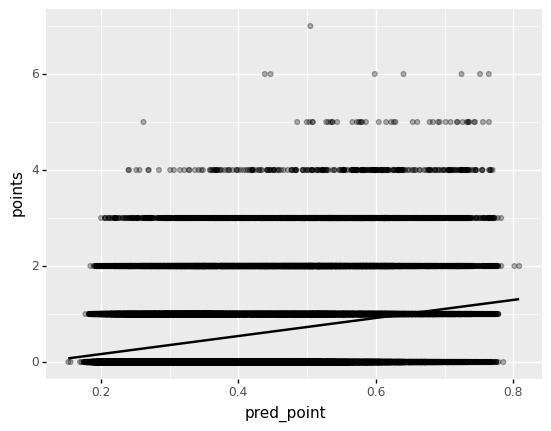

<ggplot: (200866445041)>

In [31]:
from plotnine import * 
ggplot(aes(x = 'pred_point', y = 'points'), data = dat) + geom_point(alpha = 0.3) + geom_smooth()

In [32]:
dat['round_pred'] = dat['pred_point'].apply(lambda x: np.round(x, 1))

In [33]:
dat.groupby('round_pred')['points'].mean()

round_pred
0.2    0.239531
0.3    0.357861
0.4    0.516174
0.5    0.697682
0.6    0.898902
0.7    1.201399
0.8    1.574163
Name: points, dtype: float64

In [34]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

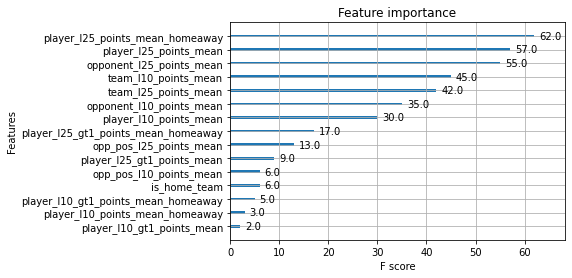

In [35]:
plot_importance(search1.best_estimator_)